# von Karman beam with clamped-free BCs


We are using the Taylor coefficients extracted via SSMTool using the normal form style parametrization. 

In [1]:
import numpy as np
from scipy.io import loadmat

In [2]:
import matplotlib.pyplot as plt

In [3]:
from taylor_to_pade.matlab_integration import *
from taylor_to_pade.approximant import TaylorSeries, PadeApproximant

In [4]:
src = 'real_FRC'

In [6]:
def get_coeff(expr):
    return expr.as_terms()[0][0][1][0][0] + 1j*expr.as_terms()[0][0][1][0][1]

In [7]:
def discard_small_coeffs(expr, tolerance = 1e-15):
    terms = sy.Add.make_args(expr)
    newexpr = 0
    for t in terms:
        if np.abs(get_coeff(t)) > tolerance:
            newexpr += t
    return newexpr

In [8]:
def discard_small_coeffs_pade(paded, tolerance = 1e-15):
    num, denom = paded.as_numer_denom()
    num = discard_small_coeffs(num, tolerance)
    denom = discard_small_coeffs(denom, tolerance)
    return num / denom

In [9]:
def generate_parametrization(list_param, order_num=3, order_denom=3, use_robust = False):
    parametrization_pade = []
    for p in list_param:
        pad = taylor_to_pade.approximant.PadeApproximant(order_numerator=order_num,
                                                         order_denominator=order_denom,
                                                         base = [p1, p2])
        pad.initialize_from_taylor(p.coefficients, use_robust = use_robust)
        parametrization_pade.append(pad)
    return parametrization_pade

In [10]:
def discard_small_coeffs(expr, tolerance = 1e-15):
    terms = sy.Add.make_args(expr)
    newexpr = 0
    for t in terms:
        if np.abs(get_coeff(t)) > tolerance:
            newexpr += t
    return newexpr

In [11]:
def discard_small_coeffs_pade(paded, tolerance = 1e-15):
    num, denom = paded.as_numer_denom()
    num = discard_small_coeffs(num, tolerance)
    denom = discard_small_coeffs(denom, tolerance)
    return num / denom

In [12]:
def return_parametrization_up_to_order_Taylor(parametrization_expressions, max_order = 30):
    parametrization = []
    for p in parametrization_expressions:
        coeff = taylor_to_pade.matlab_integration.extract_coefficients(p[0], [p1, p2], max_order)
        parametrization.append(TaylorSeries(coeff, max_order, base = [p1, p2]))
    return parametrization

In [13]:
def return_reduced_dyn_up_to_order_Taylor(reduced_dynamics_expressions, max_order = 30):
    red_dynamics = []
    for r in reduced_dynamics_expressions:
        coeff = taylor_to_pade.matlab_integration.extract_coefficients(r[0], [p1, p2], max_order)
        red_dynamics.append(TaylorSeries(coeff, max_order, base = [p1, p2]))
    for r in red_dynamics:
        r.polynomial = discard_small_coeffs(r.polynomial, tolerance = 1e-10)
    radial_variables, angle_variables, r_equations, phi_equations = taylor_to_pade.utils.convert_to_polar([p1, p2], [r.polynomial for r in red_dynamics])
    
    coeff = taylor_to_pade.matlab_integration.extract_coefficients_1d(phi_equations[0], radial_variables, max_order)
    frequency_Taylor = TaylorSeries(coeff, max_order, base = radial_variables)
    coeff = taylor_to_pade.matlab_integration.extract_coefficients_1d(r_equations[0], radial_variables, max_order)
    damping_Taylor = TaylorSeries(coeff, max_order, base = radial_variables)
    damping_curve_taylor_ = sy.lambdify(radial_variables[0], -r_equations[0]/radial_variables[0], 'numpy')
    damping_curve_taylor = lambda x : np.real(damping_curve_taylor_(x))
    return red_dynamics, frequency_Taylor, damping_Taylor, damping_curve_taylor, radial_variables, angle_variables#, r_equations, phi_equations

In [14]:
def reduced_dynamics(frequency, damping, order_num = 3, order_denom = 3, use_robust = False):
    frequency_Pade = PadeApproximant(order_denominator=order_num, order_numerator=order_num, base = radial_variables)
    damping_Pade = PadeApproximant(order_denominator=order_num, order_numerator=order_num, base = radial_variables)
    damping_Pade.initialize_from_taylor(damping.coefficients, use_robust = use_robust)
    frequency_Pade.initialize_from_taylor(frequency.coefficients, use_robust = use_robust)
    return frequency_Pade, damping_Pade

In [17]:
src_real = 'real_FRC/'


Load SSM coeffs

In [18]:
import numpy as np
from scipy.io import loadmat
mat = loadmat('vonkarman_order18_multiindex.mat')


In [19]:
import sympy as sy
p1, p2 = sy.symbols('p_1 p_2')
var = np.array([p1,p2]).reshape(-1,1)

In [20]:
%load_ext autoreload
%autoreload 2
%aimport taylor_to_pade


In [21]:
import taylor_to_pade

In [22]:
mat['W_0'] = mat['W0']
mat['R_0'] = mat['R0']
del mat['R0']
del mat['W0']

In [23]:
def unpack_it(variables, coeff, exps):
    p1, p2 = variables
    val = 0
    for ex, cc in zip(exps,coeff):
        val += cc * p1**ex[0] * p2 ** ex[1]
    return val

In [24]:
matt = mat['W_0'][0]
W0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'W_0') # get reduced dyn
parametrization_expressions = reduced_to_full(var, W0)

In [26]:
outdof = 28


In [27]:
parametrization_expressions = [parametrization_expressions[outdof],
            parametrization_expressions[17],
            parametrization_expressions[18]]

In [28]:
R0 = taylor_to_pade.matlab_integration.extract_gen_new(mat, 'R_0') # get reduced dyn
reduced_dynamics_expressions = taylor_to_pade.matlab_integration.reduced_to_full(var, R0)

In [29]:
def get_resp_at_r(r, idx):
    phi_sample = np.linspace(0, 2*np.pi, 100)
    z1 = r * np.exp(1j*phi_sample)
    zz = np.vstack((z1, np.conjugate(z1))).reshape(2,-1)
    response_taylor = np.real(parametrization[idx].evaluate(zz.T))
    return np.max(np.abs(response_taylor))

In [30]:
sample_rs = np.linspace(1e-7, 1e-3, 1000)

In [31]:
orders = np.arange(3, 10, 1)


In [32]:
calib_from_ssmtool = np.abs(0.02425)


In [33]:
epsilons = np.linspace(5e-4, 5e-2, 10) 

In [34]:
colormap = plt.cm.copper

In [35]:
selected = [0, 1,2,3,4, 5]#,6]
epsilon_range = epsilons[max(selected)] - epsilons[min(selected)]
d_epsilon = epsilon_range / len(selected)
norm = plt.cm.colors.Normalize(vmin=epsilons[min(selected)],
                               vmax=epsilons[max(selected)] )

In [36]:
from scipy import interpolate

In [37]:
from scipy.optimize import minimize

### Extract the Taylor series

In [39]:
parametrization_18 = return_parametrization_up_to_order_Taylor(parametrization_expressions,
                                                            max_order = 18)
red_dynamics_18, frequency_Taylor_18, damping_Taylor_18, damping_curve_taylor_18, radial_variables, angle_variables = return_reduced_dyn_up_to_order_Taylor(reduced_dynamics_expressions,
                                                                                                                                                max_order = 16)



In [40]:
def get_resp_at_r_pade(r, parametrization_pade, idx):
    phi_sample = np.linspace(0, 2*np.pi, 100)
    z1 = r * np.exp(1j*phi_sample)
    zz = np.vstack((z1, np.conjugate(z1))).reshape(2,-1)
    response_pade = np.real(parametrization_pade[idx].evaluate(zz.T))
    return np.max(np.abs(response_pade))

In [41]:
orders = np.arange(1, 5, 1)

In [42]:
d_epsilon

0.004583333333333334

In [43]:
depsilons = np.linspace(5e-4, 5e-2, 10) #np.linspace(0.1, 1, 5)

In [44]:
from scipy.optimize import root

In [47]:
orangecolor = [1.0, 0.5, 0.0]

In [48]:
import matplotlib as mpl

In [108]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 13, "font.family": "serif",})
plt.rcParams.update({'text.latex.preamble':r"\usepackage{amsmath}"})

Only select 3 amplitudes to compare to:

In [49]:
selected_ = [1, 4, 8] 

In [50]:
sample_rs = np.linspace(1e-7, 1e-2, 10000)

## Order-16 SSM-reduced model and FRC

/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_36064/640534161.py:23: RuntimeWarning: invalid value encountered in sqrt
  OmegaFm = lambda x: np.squeeze(frequency_Taylor.evaluate(x.reshape(-1,1))) - np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_taylor(x))**2))
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_36064/640534161.py:24: RuntimeWarning: invalid value encountered in sqrt
  OmegaFp = lambda x: np.squeeze(frequency_Taylor.evaluate(x.reshape(-1,1))) + np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_taylor(x))**2))


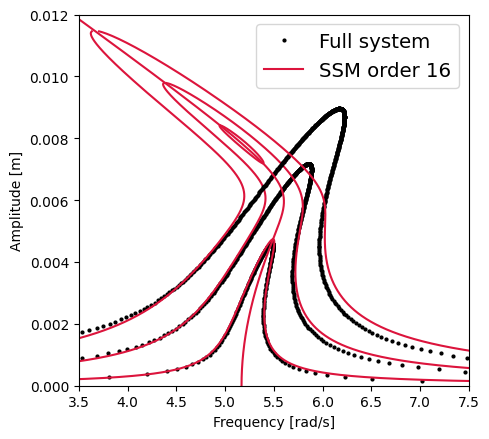

In [55]:
fig = plt.figure(figsize = (5,4.5))
ax = fig.add_subplot(111)

o2 = 16 
ind2 = -1
parametrization = return_parametrization_up_to_order_Taylor(parametrization_expressions,
                                                                max_order = o2)
red_dynamics, frequency_Taylor, damping_Taylor, damping_curve_taylor, radial_variables, angle_variables = return_reduced_dyn_up_to_order_Taylor(reduced_dynamics_expressions, max_order = o2)
amplitudes_taylor = []
for r in sample_rs:
    amplitudes_taylor.append(get_resp_at_r(r,0))
flag = True
for i in selected_:
    ep = depsilons[i]
    calibration = ep * calib_from_ssmtool
    bd = loadmat(src_real + '/data_%s/bd_nd.FRC0.0005/bd.mat' %(i+1))['bd_data']
    bd_data = bd[3,1]
    omega = bd_data[1:,7]
    experimental_omega = np.array(omega, dtype = float)
    response = np.array(bd_data[1:,26])
    experimental_amplitude = [np.max(np.abs(r[outdof,:])) for r in response]
    
    OmegaFm = lambda x: np.squeeze(frequency_Taylor.evaluate(x.reshape(-1,1))) - np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_taylor(x))**2))
    OmegaFp = lambda x: np.squeeze(frequency_Taylor.evaluate(x.reshape(-1,1))) + np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_taylor(x))**2))
    if flag:
        ax.plot(experimental_omega, experimental_amplitude, '.',c='black', markersize = 4, label = 'Full system')
    else:
        ax.plot(experimental_omega, experimental_amplitude, '.',c='black', markersize = 4)
    flag = False
    ax.plot(OmegaFm(sample_rs), amplitudes_taylor ,'-', c = 'crimson')
    ax.plot(OmegaFp(sample_rs), amplitudes_taylor,'-', c='crimson')
ax.plot(frequency_Taylor.numpy_function(sample_rs), amplitudes_taylor, '-', c='crimson',  label = 'SSM order 16')

ax.set_xlim(3.5, 7.5)
ax.set_ylim(0, 0.012)

ax.legend(loc= 'upper right', fontsize = 14.2)


ax.set_xlabel('Frequency [rad/s]')

ax.set_ylabel('Amplitude [m]')
fig.tight_layout()




## [5/5] and [5/4] gSSM-reduced model and FRC

/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_36064/3770029006.py:46: RuntimeWarning: invalid value encountered in sqrt
  OmegaFm_pade = lambda x: np.squeeze(frequency_Pade.evaluate(x.reshape(-1,1))) - np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_pade(x))**2))
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_36064/3770029006.py:47: RuntimeWarning: invalid value encountered in sqrt
  OmegaFp_pade = lambda x: np.squeeze(frequency_Pade.evaluate(x.reshape(-1,1))) + np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_pade(x))**2))


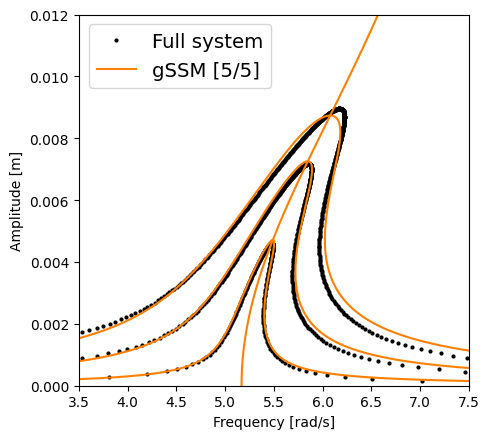

In [54]:
fig = plt.figure(figsize = (5,4.5))


ax = fig.add_subplot(111)


parametrization = return_parametrization_up_to_order_Taylor(parametrization_expressions,
                                                                max_order = o2)
red_dynamics, frequency_Taylor, damping_Taylor, damping_curve_taylor, radial_variables, angle_variables = return_reduced_dyn_up_to_order_Taylor(reduced_dynamics_expressions, max_order = o2)
amplitudes_taylor = []
for r in sample_rs:
    amplitudes_taylor.append(get_resp_at_r(r,0))
flag = True
for i in selected_:
    ep = depsilons[i]
    calibration = ep * calib_from_ssmtool
    bd = loadmat(src_real + '/data_%s/bd_nd.FRC0.0005/bd.mat' %(i+1))['bd_data']
    bd_data = bd[3,1]
    omega = bd_data[1:,7]
    experimental_omega = np.array(omega, dtype = float)
    response = np.array(bd_data[1:,26])
    outdof = 28
    experimental_amplitude = [np.max(np.abs(r[outdof,:])) for r in response]
    
    OmegaFm = lambda x: np.squeeze(frequency_Taylor.evaluate(x.reshape(-1,1))) - np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_taylor(x))**2))
    OmegaFp = lambda x: np.squeeze(frequency_Taylor.evaluate(x.reshape(-1,1))) + np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_taylor(x))**2))
    if flag:
        ax.plot(experimental_omega, experimental_amplitude, '.',c='black', markersize = 4, label = 'Full system')
    else:
        ax.plot(experimental_omega, experimental_amplitude, '.',c='black', markersize = 4)
    flag = False

    
parametrization_pade = generate_parametrization(parametrization_18, order_num =5, order_denom= 4, use_robust=True)
frequency_Pade, damping_Pade = reduced_dynamics(frequency_Taylor_18, damping_Taylor_18, order_num=5, order_denom=5, use_robust=True)
damping_curve_pade = lambda x: np.squeeze(-damping_Pade.evaluate(x.reshape(-1,1)) / np.squeeze(x) )
    

amplitudes_pade = []
for r in sample_rs:
    amplitudes_pade.append(get_resp_at_r_pade(r,parametrization_pade, 0))
for i in selected_:
    ep = depsilons[i]
    calibration = ep * calib_from_ssmtool
       
    OmegaFm_pade = lambda x: np.squeeze(frequency_Pade.evaluate(x.reshape(-1,1))) - np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_pade(x))**2))
    OmegaFp_pade = lambda x: np.squeeze(frequency_Pade.evaluate(x.reshape(-1,1))) + np.squeeze(np.sqrt(calibration**2/x**2-(damping_curve_pade(x))**2))

    ax.plot(OmegaFm_pade(sample_rs), amplitudes_pade, '-', c = orangecolor)
    ax.plot(OmegaFp_pade(sample_rs), amplitudes_pade, '-', c=orangecolor)
ax.plot(frequency_Pade.numpy_function(sample_rs), amplitudes_pade, '-', c=orangecolor, label = 'gSSM [5/5]')


ax.set_xlim(3.5, 7.5)
ax.set_ylim(0, 0.012)

ax.legend(loc='upper left', fontsize = 14.2)


ax.set_xlabel('Frequency [rad/s]')

ax.set_ylabel('Amplitude [m]')
fig.tight_layout()


## Backward integration: 

In [56]:
frequency_Pade, damping_Pade = reduced_dynamics(frequency_Taylor_18, damping_Taylor_18, order_num=6, order_denom=6, use_robust=True)


In [57]:
def derivative_polar_pade(t,x):
    # assume r, phi order
    dr = np.squeeze(damping_Pade.evaluate(np.array(x[0]).reshape(-1,1)))
    dphi = np.squeeze(frequency_Pade.evaluate(np.array(x[0]).reshape(-1,1)))
    return np.array([dr, dphi])
def derivative_polar_taylor(t,x):
    # assume r, phi order
    dr = np.squeeze(damping_Taylor_18.evaluate(np.array(x[0]).reshape(-1,1)))
    dphi = np.squeeze(frequency_Taylor_18.evaluate(np.array(x[0]).reshape(-1,1)))
    return np.array([dr, dphi])

In [58]:
def convert_to_complex(x):
    x1 = np.exp(1j*x[1,:]) * x[0,:]
    x2 = np.exp(-1j*x[1,:]) * x[0,:]
    return np.vstack((x1,x2))
def convert_to_rad_angle(x):
    x1 = np.abs(x)
    x2 = np.angle(x)
    return np.vstack((x1,x2))

In [59]:
ic_for_backward = np.array([0.00062543-0.00036913j, 0.00062543+0.00036913j])

In [60]:
ic_polar_ = np.squeeze(convert_to_rad_angle(ic_for_backward[0]))

In [62]:

T = -45.5
teval = np.linspace(0,T,2000)


In [63]:
from scipy.integrate import solve_ivp

In [65]:

sol_ssm_taylor_backward = solve_ivp(derivative_polar_taylor, [0, T], ic_polar_, t_eval = teval,  atol = 1e-8, method = 'DOP853')
sol_ssm_taylor_backward = convert_to_complex(sol_ssm_taylor_backward.y)
sol_ssm_pade_backward = solve_ivp(derivative_polar_pade, [0, T], ic_polar_, t_eval = teval, atol = 1e-6, method = 'DOP853')
sol_ssm_pade_backward = convert_to_complex(sol_ssm_pade_backward.y)

<lambdifygenerated-15>:2: RuntimeWarning: overflow encountered in power
  return -3.84935872663827e+34*r_0**15 + 2.3612646289689e+29*r_0**13 - 1.50793346027548e+24*r_0**11 + 1.03268695324083e+19*r_0**9 - 80534980448868.6*r_0**7 + 803993769.866588*r_0**5 - 19707.1397155404*r_0**3 - 0.00190777538744291*r_0
<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in add
  return -3.84935872663827e+34*r_0**15 + 2.3612646289689e+29*r_0**13 - 1.50793346027548e+24*r_0**11 + 1.03268695324083e+19*r_0**9 - 80534980448868.6*r_0**7 + 803993769.866588*r_0**5 - 19707.1397155404*r_0**3 - 0.00190777538744291*r_0
<lambdifygenerated-14>:2: RuntimeWarning: overflow encountered in power
  return -2.84888614362198e+40*r_0**16 + 1.70261882038519e+35*r_0**14 - 1.06239021214216e+30*r_0**12 + 7.04144679214576e+24*r_0**10 - 5.09968583839874e+19*r_0**8 + 425032445383959.0*r_0**6 - 4581040982.809*r_0**4 + 93552.6939497371*r_0**2 + 5.1680607373178
<lambdifygenerated-14>:2: RuntimeWarning: invalid value 

(-46.0, -28.0)

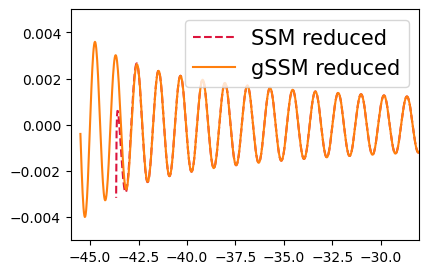

In [71]:
ff = plt.figure(figsize = (4.5, 3))
ax = ff.add_subplot(111)

ax.plot(teval[:-81], np.real(sol_ssm_taylor_backward[0,:]), '--', c='Crimson',  label = 'SSM reduced')
ax.plot(teval, np.real(sol_ssm_pade_backward[0,:]), '-', c='C1',  label = 'gSSM reduced')


ax.legend(loc = 'upper right', fontsize = 15)
ax.set_ylim(-0.005, 0.005)
ax.set_xlim(-46, -28)